In [1]:
import keras
import numpy as np
import datetime
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import keras.backend as K

from keras.models import Sequential, Model, Input
from keras.layers import Dense, BatchNormalization, Activation, \
                                LeakyReLU, Dropout, Embedding, \
                                multiply, Flatten, add, dot
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.utils.vis_utils import model_to_dot

from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS                           
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from keras_tqdm import TQDMNotebookCallback
from IPython.display import SVG
from tqdm import tqdm_notebook
from collections import namedtuple

Using TensorFlow backend.


In [2]:
K.backend()

'tensorflow'

In [3]:
import mxnet as mx 
mx.test_utils.list_gpus()

range(0, 0)

In [4]:
movies = pd.read_csv('data/ml-latest-medium/movies.csv')

In [5]:
reviews = pd.read_csv('data/ml-latest-medium/ratings.csv')

In [6]:
df = reviews.merge(movies, on='movieId')

In [7]:
# df[df.drop_duplicates(subset='movieId').title.value_counts() > 1]

In [8]:
df.userId.max(), df.userId.drop_duplicates().shape

(138493, (138493,))

In [9]:
# umap = df.userId.drop_duplicates().sort_values(ascending=True).reset_index().userId
mmap = df.movieId.drop_duplicates().sort_values(ascending=True).reset_index().movieId
# umap = {v:k for k,v in umap.items()}
mmap = {v:k for k,v in mmap.items()}
# df.userId = df.userId.map(umap)
df.movieId = df.movieId.map(mmap)

In [10]:
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,3.5,1112486027,Jumanji (1995),Adventure|Children|Fantasy
1,5,1,3.0,851527569,Jumanji (1995),Adventure|Children|Fantasy
2,13,1,3.0,849082742,Jumanji (1995),Adventure|Children|Fantasy
3,29,1,3.0,835562174,Jumanji (1995),Adventure|Children|Fantasy
4,34,1,3.0,846509384,Jumanji (1995),Adventure|Children|Fantasy


In [11]:
# df.genres.value_counts()

In [127]:
df_train, df_eval = train_test_split(df, test_size=0.1, shuffle=True)
# df_eval, df_test = train_test_split(df_, test_size=0.1)

def make_data(df):
    return df.userId.values, df.movieId.values, df.rating.values

U_train, M_train, R_train = make_data(df_train)
U_eval, M_eval, R_eval = make_data(df_eval)
# U_test, M_test, R_test = make_data(df_test)

In [128]:
MAX_U = df.userId.max()
MAX_M = df.movieId.max()
MAX_U, MAX_M

(138493, 26743)

In [129]:
EMBEDDINGS_DIM = 30
BIAS_EMBEDDINGS_DIM = EMBEDDINGS_DIM
BATCH_SIZE = 2**18

def build_model():
    u_input = Input(shape=(1,), dtype='int32')
    m_input = Input(shape=(1,), dtype='int32')
    u_branch = Embedding(MAX_U+1, EMBEDDINGS_DIM, name='user')(u_input)
    u_branch = Dropout(0.2)(u_branch)
    m_branch = Embedding(MAX_M+1, EMBEDDINGS_DIM, name='movie')(m_input)
    m_branch = Dropout(0.2)(m_branch)
    u_bias = Embedding(MAX_U+1, BIAS_EMBEDDINGS_DIM, name='user_bias')(u_input)
    m_bias = Embedding(MAX_M+1, BIAS_EMBEDDINGS_DIM, name='movie_bias')(m_input)
    joint1 = dot([u_branch, m_branch], axes=-1)
    middle = Flatten()(joint1)
    joint2 = add([u_bias, middle, m_bias])
    sequence = Sequential([
        Flatten(),
        Dense(256),
        Activation('relu'),
        Dropout(0.2),
        Dense(1),
    ])
    output = sequence(joint2)
    return Model([u_input, m_input], output)

In [135]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred), axis=-1))

model = build_model()

model.compile(
    loss='mae',
    optimizer='adam',
    metrics=[rmse],
)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
user (Embedding)                (None, 1, 30)        4154820     input_15[0][0]                   
__________________________________________________________________________________________________
movie (Embedding)               (None, 1, 30)        802320      input_16[0][0]                   
__________________________________________________________________________________________________
dropout_9 

In [136]:
# n = 25

In [137]:
n += 1

In [138]:
LOGDIR = '/tmp/runs'

# with open(f'{LOGDIR}/metadata.tsv', 'w') as fi:
#     np.savetxt(fi, R_eval)
# embeddings_metadata = {
#     'movie': f'{LOGDIR}/metadata.tsv',
# }

tensorboard = TensorBoard(
    log_dir=f'{LOGDIR}/{n}',
    update_freq='batch',
#     histogram_freq=10,
#     write_graph=False,
#     embeddings_freq=1,
#     embeddings_layer_names=['movie'],
#     embeddings_metadata=embeddings_metadata,
#     embeddings_data=[U_eval, M_eval],
)

In [139]:
inputs = [U_train, M_train]
outputs = R_train

inputs_eval = [U_eval, M_eval]
outputs_eval = R_eval

print(f'Run: {n} Batch Size: {BATCH_SIZE}')
model.fit(
    x=inputs,
    y=outputs,
    batch_size=BATCH_SIZE,
    epochs=24,
    validation_data=(inputs_eval, outputs_eval),
    verbose=False,
    callbacks=[TQDMNotebookCallback(), tensorboard],
)

Run: 33 Batch Size: 262144


In [140]:
embedding_u = model.get_layer("user").get_weights()[0]
embedding_m = model.get_layer("movie").get_weights()[0]
results = embedding_m
embedding_u.shape, embedding_m.shape

((138494, 30), (26744, 30))

In [141]:
# SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [142]:
results = PCA(n_components=3).fit_transform(embedding_m)
results.shape

(26744, 3)

In [143]:
g = pd.DataFrame({
    'movieId': df.drop_duplicates(subset='movieId').sort_values(by='movieId', ascending=True).title.values,
    'x1': results[:, 0],
    'x2': results[:, 1],
    'x3': results[:, 2],
#     'x4': results[:, 3],
}).drop_duplicates()

In [144]:
g.nsmallest(10, ['x1'])

,movieId,x1,x2,x3
10026,F for Fake (Vérités et mensonges) (1973),-0.491283,0.089093,-0.041550
14796,"Holy Innocents, The (Santos inocentes, Los) (1...",-0.468389,0.051958,-0.013234
10751,Shadows of Our Forgotten Ancestors (Tini zabut...,-0.461648,0.109785,0.165168
9977,Maidens in Uniform (Mädchen in Uniform) (1931),-0.454711,0.074189,-0.115190
6063,Gerry (2002),-0.452466,0.430455,-0.022343
10819,"Wind, The (1928)",-0.450727,-0.078633,-0.246245
23944,Force Majeure (Turist) (2014),-0.447167,0.145478,0.108154
11026,"Earth Is a Sinful Song, The (Maa on syntinen l...",-0.437697,-0.092284,-0.088353
3585,Eraserhead (1977),-0.436900,0.479260,0.016895
17165,"Tree of Life, The (2011)",-0.436566,0.284328,-0.054131


In [145]:
g.nlargest(10, ['x1'])

,movieId,x1,x2,x3
5733,Left Behind II: Tribulation Force (2002),0.642071,-0.055500,-0.157865
3502,Battlefield Earth (2000),0.618995,0.266555,0.025620
7787,Police Academy: Mission to Moscow (1994),0.618435,0.298555,0.118414
10503,Left Behind: World at War (2005),0.617891,-0.086231,-0.137918
5716,Half Past Dead (2002),0.602497,0.108714,0.015240
4048,Left Behind: The Movie (2000),0.582002,-0.126207,-0.110105
7876,White Chicks (2004),0.579359,0.273695,-0.263774
12050,Daddy Day Camp (2007),0.577558,0.128837,-0.063138
7983,Catwoman (2004),0.576042,0.096424,-0.082874
10929,Larry the Cable Guy: Health Inspector (2006),0.575491,0.213301,-0.097619


In [146]:
g.nsmallest(10, ['x2'])

,movieId,x1,x2,x3
12617,Expelled: No Intelligence Allowed (2008),0.550430,-0.386263,-0.212577
26328,The Coven (2015),-0.177224,-0.373833,0.025982
1650,Legal Deceit (1997),0.025363,-0.362211,-0.264308
17055,Voices from the List (2004),-0.084845,-0.355584,-0.138595
23098,God's Not Dead (2014),0.255486,-0.353577,0.025555
20458,Tale of Tales (Skazka skazok) (1979),-0.423230,-0.350100,-0.215219
1273,Field of Dreams (1989),0.026809,-0.349674,-0.083396
21594,Salinger (2013),-0.193698,-0.343570,0.051226
23902,No Good Deed (2014),0.286164,-0.342077,-0.070183
22917,Superpower (2008),-0.226642,-0.332606,-0.025593


In [147]:
g.nlargest(10, ['x2'])

,movieId,x1,x2,x3
4161,Freddy Got Fingered (2001),0.223290,0.822073,0.161319
5675,Night of the Zombies (a.k.a. Batallion of the ...,0.040791,0.657120,0.064063
2375,"Texas Chainsaw Massacre 2, The (1986)",-0.005997,0.651778,-0.234152
14912,"Room, The (2003)",0.086662,0.608836,0.093417
5792,I Spit on Your Grave (Day of the Woman) (1978),0.140255,0.602334,0.013982
5064,Night of the Zombies (a.k.a. Hell of the Livin...,0.065371,0.591193,-0.058014
4278,Pootie Tang (2001),0.048356,0.586252,-0.126975
3844,"Slumber Party Massacre, The (1982)",0.245828,0.574628,-0.156493
1840,Plan 9 from Outer Space (1959),-0.134340,0.569585,-0.051789
8284,Seed of Chucky (Child's Play 5) (2004),0.145310,0.559072,-0.256268


In [148]:
g.nsmallest(10, ['x3'])

,movieId,x1,x2,x3
13076,High School Musical 3: Senior Year (2008),0.459074,0.164601,-0.498431
13131,Beverly Hills Chihuahua (2008),0.238095,0.037413,-0.495139
4138,Spy Kids (2001),0.059759,-0.019553,-0.486302
5407,Spy Kids 2: The Island of Lost Dreams (2002),0.186421,0.042226,-0.482904
2299,Babe: Pig in the City (1998),-0.088211,-0.036353,-0.460690
11071,High School Musical (2006),0.340825,0.044076,-0.457918
2230,Bride of Chucky (Child's Play 4) (1998),0.175557,0.504387,-0.435531
579,"Brady Bunch Movie, The (1995)",0.052107,0.060105,-0.410972
6456,Spy Kids 3-D: Game Over (2003),0.245940,0.248538,-0.409292
17922,First Love (1939),0.078691,0.056356,-0.404740


In [149]:
g.nlargest(10, ['x3'])

,movieId,x1,x2,x3
4052,"Million Dollar Hotel, The (2001)",0.025894,0.339012,0.522297
10842,London (2005),0.264027,0.228123,0.433223
1284,Mad Dog Time (1996),0.079679,0.151747,0.422268
7265,"United States of Leland, The (2003)",0.041470,0.016634,0.418973
17,Four Rooms (1995),0.021563,0.038943,0.412716
18141,Another Happy Day (2011),-0.109687,-0.013661,0.403742
10550,Revolver (2005),0.100312,0.157571,0.391784
11218,Tideland (2005),-0.073511,0.273977,0.384826
1800,Fear and Loathing in Las Vegas (1998),-0.200885,0.352117,0.380065
3405,Roadside Prophets (1992),-0.035002,0.155925,0.378844


In [150]:
embedding_ub = model.get_layer("user_bias").get_weights()[0]
embedding_mb = model.get_layer("movie_bias").get_weights()[0]

In [151]:
results_mb = PCA(n_components=1).fit_transform(embedding_mb)
results_ub = PCA(n_components=1).fit_transform(embedding_ub)
results_ub.shape

In [152]:
mbmax, mbmin = results_mb.argmax(), results_mb.argmin() 
ubmax, ubmin = results_ub.argmax(), results_ub.argmin() 

In [153]:
df[df.userId==ubmax].head(20)

,userId,movieId,rating,timestamp,title,genres


In [79]:
df[df.userId==ubmin].head(20)

,userId,movieId,rating,timestamp,title,genres
52767,68060,31,0.5,1269314884,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
96910,68060,46,0.5,1269236112,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
142179,68060,49,0.5,1269235755,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
227687,68060,250,0.5,1269235975,Interview with the Vampire: The Vampire Chroni...,Drama|Horror
268579,68060,257,5.0,1269227682,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
309073,68060,290,0.5,1269235764,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller
355053,68060,293,5.0,1269236108,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
420495,68060,315,5.0,1269227672,"Shawshank Redemption, The (1994)",Crime|Drama
461592,68060,333,0.5,1269236271,What's Eating Gilbert Grape (1993),Drama
487553,68060,363,0.5,1269235991,"Mask, The (1994)",Action|Comedy|Crime|Fantasy


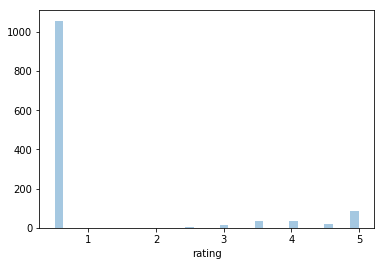

In [80]:
sns.distplot(df[df.userId==68060].rating, kde=False)

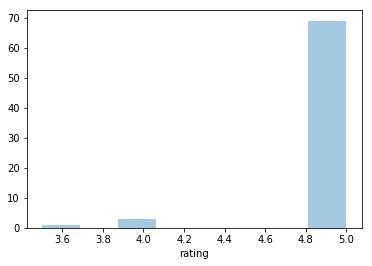

In [81]:
sns.distplot(df[df.userId==108389].rating, kde=False)

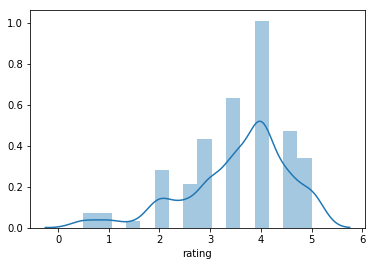

In [82]:
sns.distplot(df[df.userId==1254].rating)

In [154]:
with open('tensors.tsv', 'w') as fi:
    np.savetxt(fi, embedding_m, delimiter='\t')

In [155]:
labels_m = df.drop_duplicates(subset='movieId').sort_values(by='movieId', ascending=True)[['title', 'genres']]
labels_m.to_csv('metadata.tsv', sep='\t', index=0)